In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import random
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import os
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 3090
GPU memory: 24252.69 MB


In [3]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

NN = 40

h = 1 / NN
x = np.linspace(0, 1, NN + 1)
y = np.linspace(0, 1, NN + 1)
Y, X = np.meshgrid(x, y)

id = np.identity(NN - 1)
d1= np.identity(NN - 1)
d1[0][1] = 1
d1[NN - 2][NN - 3] = 1
for i in range(0, NN - 1):
    d1[i][i] = -2
    if (i >= 1) and (i <= NN - 3):
        d1[i][i - 1] = 1
        d1[i][i + 1] = 1
D = np.kron(id, d1) + np.kron(d1, id)

del x, y, X, Y, id, d1

In [4]:
def solve_modified_helmholtz(N, k, f_values, g_boundary_values):
    """
    Solve the modified Helmholtz equation on [0,1]^2 using finite difference method.

    PDE: u - k * Δu = f,   on domain [0,1]^2
         u = g,            on boundary

    Parameters:
    ----------
    N : int
        Number of grid intervals (i.e., total grid points per axis is N+1).
    k : float
        Coefficient in the modified Helmholtz equation.
    f_values : np.ndarray
        Array of shape (N+1, N+1), containing values of source term f(x, y) on the grid.
    g_boundary_values : np.ndarray
        Array of shape (N+1, N+1), containing Dirichlet boundary values g(x, y) only on the boundary.
        Non-boundary entries in this array are ignored.

    Returns:
    -------
    u_full : np.ndarray
        Solution u(x, y) on the full (N+1, N+1) grid including boundaries.
    """
    assert(N == NN)

    # Extract source term on interior grid only
    b = f_values[1:-1, 1:-1]  # shape (N-1, N-1)

    # Boundary values
    g_D = g_boundary_values  # shape (N+1, N+1)

    A = np.identity((NN - 1) * (NN - 1)) - k * D / (h ** 2)

    A_sparse = sp.csr_matrix(A)

    # Modify RHS b to account for boundary contributions
    b[:, 0] += k / h**2 * g_D[1:N, 0]     # left boundary
    b[:, -1] += k / h**2 * g_D[1:N, -1]   # right boundary
    b[0, :] += k / h**2 * g_D[0, 1:N]     # bottom boundary
    b[-1, :] += k / h**2 * g_D[-1, 1:N]   # top boundary
    b = b.flatten()  # flatten to vector of size (N-1)^2

    # Solve the linear system
    u_inner = spla.spsolve(A_sparse, b).reshape((N - 1, N - 1))

    # Combine with boundary to form full solution
    u_full = np.zeros((N + 1, N + 1))
    u_full[1:-1, 1:-1] = u_inner
    u_full[0, :] = g_D[0, :]     # bottom
    u_full[-1, :] = g_D[-1, :]   # top
    u_full[:, 0] = g_D[:, 0]     # left
    u_full[:, -1] = g_D[:, -1]   # right

    return u_full

In [5]:
from scipy.spatial.distance import cdist

def generate_grf(grid_points, length_scale, sigma, seed=None):
    """
    Generate a Gaussian random field (GRF) on a 2D grid using an RBF kernel.

    Parameters:
    ----------
    grid_points : np.ndarray, shape (M, 2)
        List of 2D coordinates where the GRF is evaluated.
    length_scale : float
        RBF kernel length scale (controls smoothness).
    sigma : float
        Standard deviation of the GRF.
    seed : int or None
        Random seed.

    Returns:
    -------
    sample : np.ndarray, shape (M,)
        One realization of the GRF at the grid points.
    """
    if seed is not None:
        np.random.seed(seed)

    dists = cdist(grid_points, grid_points, metric='euclidean')
    cov_matrix = sigma ** 2 * np.exp(- (dists ** 2) / (2 * length_scale ** 2))

    return np.random.multivariate_normal(mean=np.zeros(len(grid_points)), cov=cov_matrix)

In [6]:
def generate_gaussian(nx, ny, seed=None):
    if seed is not None:
        np.random.seed(seed)

    f = np.random.randn(nx, ny)
    f = gaussian_filter(f, sigma=np.random.randint(1, 5))
    
    return f

In [7]:
def generate_sincos(nx, ny, seed=None):
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)

    if seed is not None:
        np.random.seed(seed)

    r = np.random.choice([1, 2, 3, 4])

    if r == 1:
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        f = a * np.sin(b * np.pi * X) * np.sin(c * np.pi * Y)
        
    if r == 2:
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        f = a * np.cos(b * np.pi * X) * np.cos(c * np.pi * Y)

    if r == 3:
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        f = a * np.sin(b * np.pi * X) * np.cos(c * np.pi * Y)

    if r == 4:
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        f = a * np.cos(b * np.pi * X) * np.sin(c * np.pi * Y)

    return f

In [8]:
def generate_dataset(num_samples, N, k_list, length_scale_list, sigma_list, seed_base=0):
    """
    Generate dataset for training the Modified Helmholtz equation solver.

    Parameters:
    ----------
    num_samples : int
        Total number of samples to generate.
    N : int
        Grid resolution: number of intervals along each axis (grid is (N+1)x(N+1)).
    k_list : list of float
        List of PDE parameters k to sample from.
    length_scale_list : list of float
        List of GRF length scales to use (controls smoothness).
    sigma_list : list of float
        List of GRF standard deviations to use.
    seed_base : int
        Base random seed for reproducibility.

    Returns:
    -------
    data_list : list of dict
        Each element is a dict with keys: 'k', 'f', 'g', 'u',
        where 'f', 'g', and 'u' are 2D arrays of shape (N+1, N+1).
    """

    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.flatten(), Y.flatten()], axis=-1)  # (M, 2)

    k_list_out = []
    g_list_out = []
    u_list_out = []

    for i in tqdm(range(num_samples), desc="Processing Samples"):
        # Select k, length_scale, sigma
        k = np.random.choice(k_list)
        length_scale_f = np.random.choice(length_scale_list)
        sigma_f = np.random.choice(sigma_list)
        length_scale_g = np.random.choice(length_scale_list)
        sigma_g = np.random.choice(sigma_list)

        # Generate samples for f and g
        r = np.random.choice([1, 2, 3])
        if r == 1:
            f_sample = generate_grf(points, length_scale_f, sigma_f, seed=seed_base + 2 * i).reshape(N + 1, N + 1)
            g_sample = generate_grf(points, length_scale_g, sigma_g, seed=seed_base + 2 * i + 1).reshape(N + 1, N + 1)
        if r == 2:
            f_sample = generate_gaussian(N + 1, N + 1, seed=seed_base + 2 * i).reshape(N + 1, N + 1)
            g_sample = generate_gaussian(N + 1, N + 1, seed=seed_base + 2 * i + 1).reshape(N + 1, N + 1)
        if r == 3:
            f_sample = generate_sincos(N + 1, N + 1, seed=seed_base + 2 * i).reshape(N + 1, N + 1)
            g_sample = generate_sincos(N + 1, N + 1, seed=seed_base + 2 * i + 1).reshape(N + 1, N + 1)
        f_sample[:, :] = 0.0    # ZERO source term
        g_sample[1:-1, 1:-1] = 0.0  # Ensure g only has boundary values

        # Solve the PDE
        u = solve_modified_helmholtz(N, k, f_sample, g_sample)

        # Save data sample
        k_list_out.append(k)
        g_list_out.append(np.concatenate([
                            g_sample[0, :],              # top (0 到 N)
                            g_sample[1:, N],             # right (1 到 N)
                            g_sample[N, N-1::-1],        # bottom (N-1 到 0)
                            g_sample[N-1:0:-1, 0]        # left (N-1 到 1)
                        ]).reshape(1, 4 * N))
        u_list_out.append(u.reshape(1, (N + 1) * (N + 1)))

    return k_list_out, g_list_out, u_list_out

In [9]:
k_list = np.linspace(0.05, 0.1, 11)
length_scale_list = [0.1, 0.2, 0.4]
sigma_list = [0.5, 1.0, 2.0]

# File names for individual variables
k_file = 'list_k.npy'
g_file = 'list_g.npy'
u_file = 'list_u.npy'

# Check if all files exist
if all(os.path.exists(f) for f in [k_file, g_file, u_file]):
    print("Loading existing data...")
    k_list_out = np.load(k_file, allow_pickle=True)
    g_list_out = np.load(g_file, allow_pickle=True)
    u_list_out = np.load(u_file, allow_pickle=True)
else:
    print("Generating new data...")
    
    k_list_out, g_list_out, u_list_out = generate_dataset(num_samples=25000, N=40, k_list=k_list, length_scale_list=length_scale_list, sigma_list=sigma_list, seed_base=42)

    # Save each variable separately
    np.save(k_file, k_list_out, allow_pickle=True)
    np.save(g_file, g_list_out, allow_pickle=True)
    np.save(u_file, u_list_out, allow_pickle=True)

Loading existing data...


In [10]:
k_np = np.vstack(k_list_out)
g_np = np.vstack(g_list_out)
u_np = np.vstack(u_list_out)
k_np.shape, g_np.shape, u_np.shape

((50000, 1), (50000, 160), (50000, 1681))

In [11]:
tau_torch = torch.tensor(k_np, dtype=torch.float32)
g_torch = torch.tensor(g_np, dtype=torch.float32)
u_torch = torch.tensor(u_np, dtype=torch.float32)
tau_torch.shape, g_torch.shape, u_torch.shape

(torch.Size([50000, 1]), torch.Size([50000, 160]), torch.Size([50000, 1681]))

In [12]:
tau_torch = tau_torch[0:25000, :]
g_torch = g_torch[0:25000, :]
tau_torch = tau_torch[0:25000, :]
tau_torch.shape, g_torch.shape, u_torch.shape

(torch.Size([25000, 1]), torch.Size([25000, 160]), torch.Size([50000, 1681]))

In [13]:
class DeepONet(nn.Module):
    def __init__(self, g_dim, hidden_dim):
        super().__init__()
        # Branch Net dim_input = 1 + f_dim + g_dim
        self.g_dim = g_dim
        self.branch_net = nn.Sequential(
            nn.Linear(1 + g_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.trunk_net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, k, g, x):
        """
        k: (B, 1)
        g: (B, g_dim)
        x: (M, 2)   
        """
        branch_input = torch.cat([k, g], dim=1)  # shape (B, 1+f_dim+g_dim)
        branch_out = self.branch_net(branch_input)  # shape (B, H)
        trunk_out = self.trunk_net(x)               # shape (M, 2)

        return torch.einsum('bi,mi->bm', branch_out, trunk_out)

In [14]:
test_size = int(g_torch.shape[0] * 0.2)

indices = torch.randperm(g_torch.shape[0])

test_indices = indices[:test_size]
train_indices = indices[test_size:]

tau_train, tau_test = tau_torch[train_indices], tau_torch[test_indices]
g_train, g_test = g_torch[train_indices], g_torch[test_indices]
u_train, u_test = u_torch[train_indices], u_torch[test_indices]

In [15]:
x_coords = np.linspace(0, 1, NN + 1)
xx, yy = np.meshgrid(x_coords, x_coords)
x = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32).to(device)  # (M, 2)

In [16]:
M = (NN + 1) * (NN + 1)
net = DeepONet(g_dim = 4 * NN, hidden_dim = M // 4).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5000)
loss_fn = nn.MSELoss()

In [45]:
epochs = 100000
best_test_loss = float('inf')

tau_train = tau_train.to(device)
g_train = g_train.to(device)
u_train = u_train.to(device)
tau_test = tau_test.to(device)
g_test = g_test.to(device)
u_test = u_test.to(device)

for epoch in range(epochs):
    net.train()
    
    pred = net(tau_train, g_train, x)
    loss = loss_fn(pred, u_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    net.eval()
    with torch.no_grad():
        test_pred = net(tau_test, g_test, x)
        test_loss = loss_fn(test_pred, u_test).item()
        scheduler.step(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1} / {epochs} | Train Loss: {loss.item():.8f} | Test Loss: {test_loss:.8f} | lr: {scheduler.get_last_lr()}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(net.state_dict(), "net.pth")

Epoch 100 / 100000 | Train Loss: 0.19675967 | Test Loss: 0.19100538 | lr: [0.0001]
Epoch 200 / 100000 | Train Loss: 0.13422750 | Test Loss: 0.13524681 | lr: [0.0001]
Epoch 300 / 100000 | Train Loss: 0.10231895 | Test Loss: 0.10000899 | lr: [0.0001]
Epoch 400 / 100000 | Train Loss: 0.07092772 | Test Loss: 0.06971018 | lr: [0.0001]
Epoch 500 / 100000 | Train Loss: 0.05596200 | Test Loss: 0.05461191 | lr: [0.0001]
Epoch 600 / 100000 | Train Loss: 0.04946385 | Test Loss: 0.04831285 | lr: [0.0001]
Epoch 700 / 100000 | Train Loss: 0.03680117 | Test Loss: 0.03470018 | lr: [0.0001]
Epoch 800 / 100000 | Train Loss: 0.02707370 | Test Loss: 0.02628185 | lr: [0.0001]
Epoch 900 / 100000 | Train Loss: 0.02170732 | Test Loss: 0.02116202 | lr: [0.0001]
Epoch 1000 / 100000 | Train Loss: 0.02141403 | Test Loss: 0.02116412 | lr: [0.0001]
Epoch 1100 / 100000 | Train Loss: 0.01888810 | Test Loss: 0.01832517 | lr: [0.0001]
Epoch 1200 / 100000 | Train Loss: 0.01768636 | Test Loss: 0.01712936 | lr: [0.0001]
E

In [17]:
def U(tau, x):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    return torch.exp(-np.sqrt(1 + 1 / tau) * x1) * torch.sin(x2)


def computeErrors(u_exact, u_pre, printOrNot):
    if isinstance(u_exact, np.ndarray):
        u_exact = torch.from_numpy(u_exact)
    if isinstance(u_pre, np.ndarray):
        u_pre = torch.from_numpy(u_pre)
    
    error = u_exact - u_pre
    l2_norm_abs = torch.norm(error, p=2).item() / torch.sqrt(torch.tensor(error.numel(), dtype=torch.float))
    max_norm_abs = torch.norm(error, p=float('inf')).item()
    l2_norm_rel = torch.norm(error, p=2).item() / torch.norm(u_exact, p=2).item()
    max_norm_rel = torch.norm(error, p=float('inf')).item() / torch.norm(u_exact, p=float('inf')).item()  
    
    l2_norm_rel_percent = l2_norm_rel * 100
    max_norm_rel_percent = max_norm_rel * 100
    
    if printOrNot == True:
        print(f"Absolute L2 Norm Error: {l2_norm_abs:.6f}")
        print(f"Absolute Max Norm Error: {max_norm_abs:.6f}")
        print(f"Relative L2 Norm Error: {l2_norm_rel_percent:.4f}%")
        print(f"Relative Max Norm Error: {max_norm_rel_percent:.4f}%")

    return l2_norm_rel


def plotSolutions(u_exact, u_pre, N):
    if isinstance(u_exact, torch.Tensor):
        u_exact = u_exact.cpu().detach().numpy()
    if isinstance(u_pre, torch.Tensor):
        u_pre = u_pre.cpu().detach().numpy()

    u_exact = u_exact.reshape((N, N))
    u_pre = u_pre.reshape((N, N))
    error = u_exact - u_pre
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    cax1 = axs[0].imshow(u_pre, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[0].set_title('Predicted Solution')
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(u_exact, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[1].set_title('Exact Solution')
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(np.abs(error), cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[2].set_title('Error')
    fig.colorbar(cax3, ax=axs[2])

    plt.show()

In [ ]:
def evaluate_DeepOnet_Model(model, tau):
    """
    Evaluate trained DeepONet model on a manufactured solution.

    Args:
        model: Trained DeepONet model
        tau: scalar PDE parameter (k)
        device: computation device ('cuda' or 'cpu')

    Returns:
        l2_rel_error: relative L2 error
    """

    # ========== Step 1: prepare test data ==========

    # Build test grid
    x_vals = np.linspace(0, 1, 41)
    X, Y = np.meshgrid(x_vals, x_vals)
    x_grid = np.stack([X.flatten(), Y.flatten()], axis=1)  # (1681, 2)
    x_tensor = torch.tensor(x_grid, dtype=torch.float32).to(device)


    # x_tensor = torch.zeros(41 * 41, 2).to(device)
    # for i in range(41):
    #     for j in range(41):
    #         x_tensor[i * 41 + j, 0] = 1 * j / (41 - 1) 
    #         x_tensor[i * 41 + j, 1] = 1 * i / (41 - 1)  

    # Compute f(x), u(x)
    with torch.no_grad():
        u_exact_tensor = U(tau, x_tensor).reshape(1, -1)       # (1, 1681)

    # Build g from f (only use boundary entries)
    u_np_2d = u_exact_tensor.cpu().numpy().reshape(41, 41)
    g_boundary = np.concatenate([
        u_np_2d[0, :],            
        u_np_2d[1:, 40],          
        u_np_2d[40, 39::-1],        
        u_np_2d[39:0:-1, 0],       
    ])

    g_tensor = torch.tensor(g_boundary.reshape(1, -1), dtype=torch.float32).to(device)  # (1, 160)

    # k
    k_tensor = torch.tensor([[tau]], dtype=torch.float32).to(device)

    # ========== Step 2: model prediction ==========
    model.eval()
    with torch.no_grad():
        u_pred_tensor = model(k_tensor, g_tensor, x_tensor)  # (1, 1681)

    # ========== Step 3: error and visualization ==========
    u_exact = u_exact_tensor.view(-1)
    u_pred = u_pred_tensor.view(-1)

    plotSolutions(u_exact, u_pred, N=41)

    computeErrors(u_exact.reshape(41, 41)[1:-1, 1:-1].reshape(-1), u_pred.reshape(41, 41)[1:-1, 1:-1].reshape(-1), 1)

In [24]:
net.load_state_dict(torch.load("net.pth", map_location=device))
net.eval()  

/tmp/ipykernel_2280/364260428.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("net.pth", map_location=device))


DeepONet(
  (branch_net): Sequential(
    (0): Linear(in_features=161, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=2, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
)

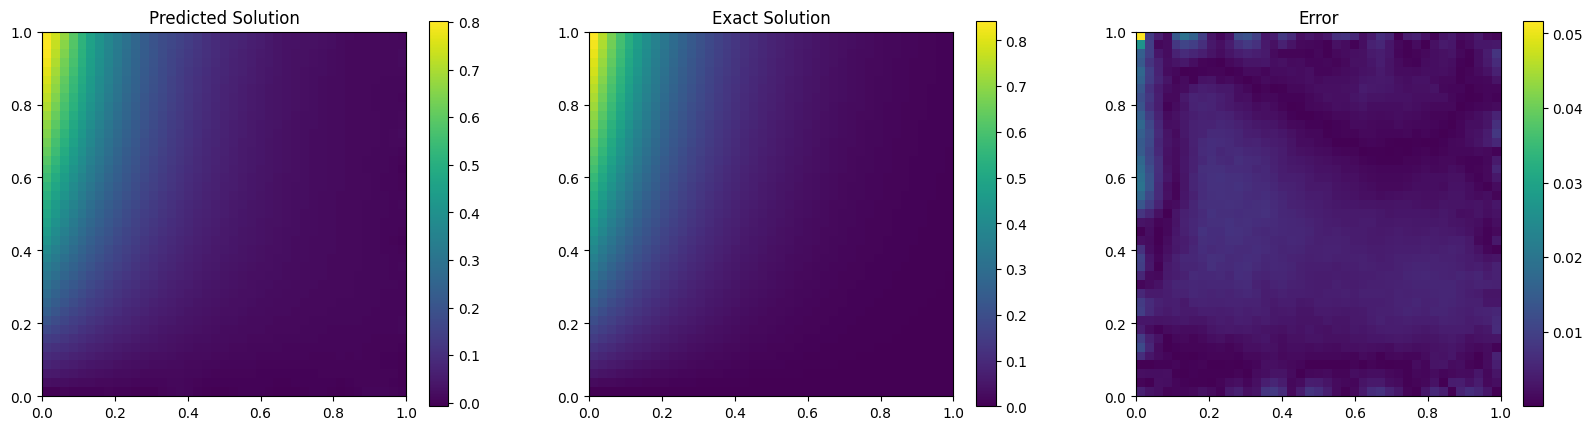

Absolute L2 Norm Error: 0.003833
Absolute Max Norm Error: 0.013306
Relative L2 Norm Error: 2.3349%
Relative Max Norm Error: 1.8027%


In [25]:
evaluate_DeepOnet_Model(net, 0.05)

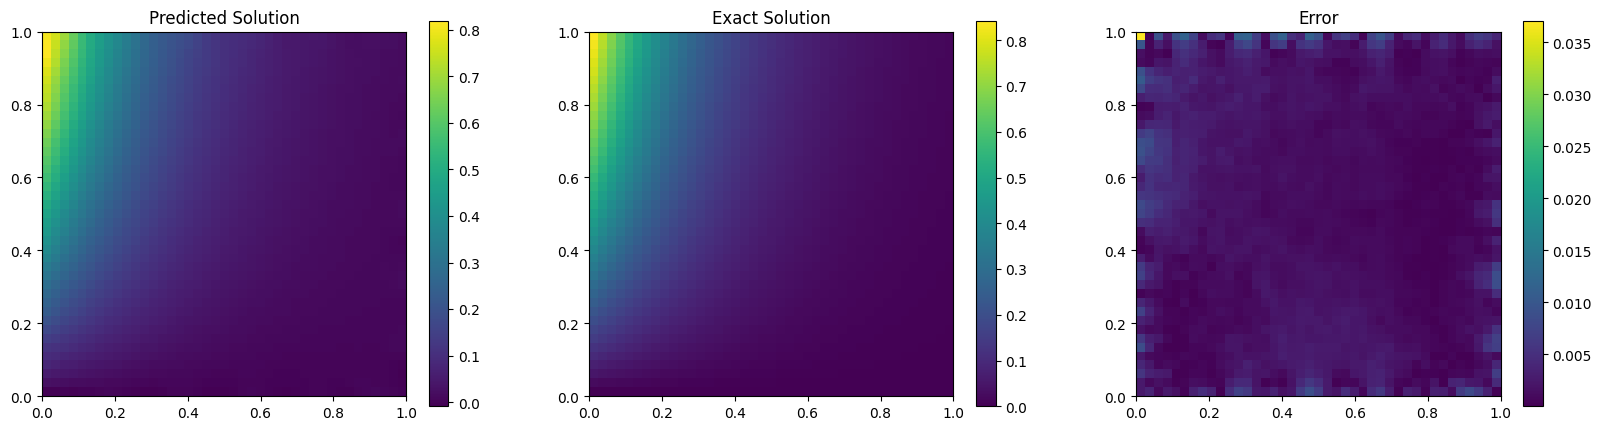

Absolute L2 Norm Error: 0.002017
Absolute Max Norm Error: 0.008249
Relative L2 Norm Error: 1.1381%
Relative Max Norm Error: 1.1011%


In [26]:
evaluate_DeepOnet_Model(net, 0.067)

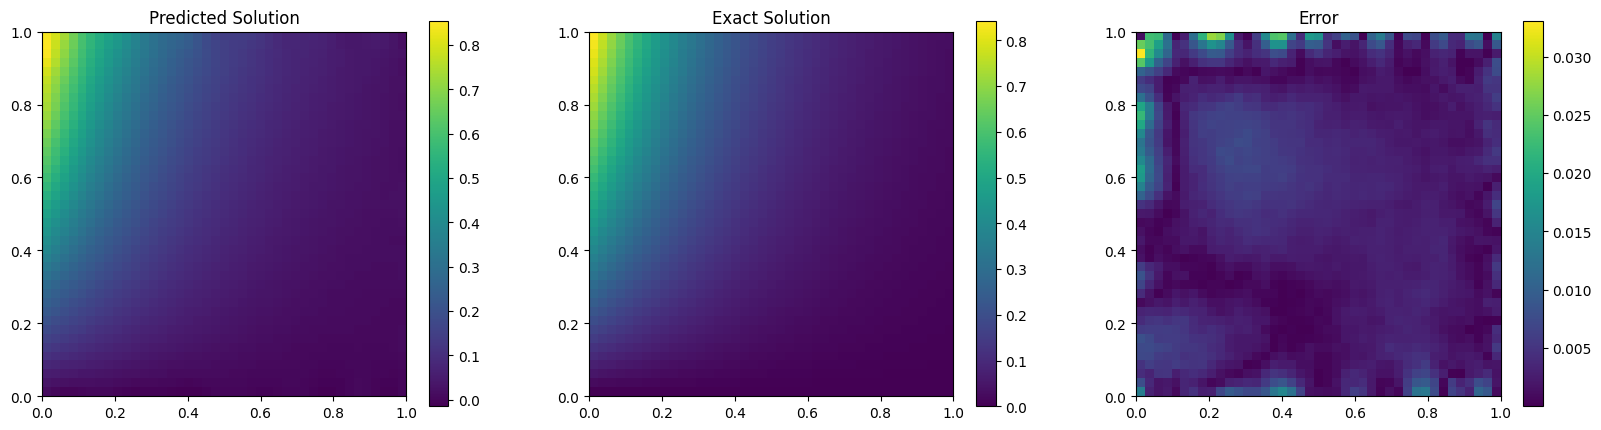

Absolute L2 Norm Error: 0.003818
Absolute Max Norm Error: 0.023148
Relative L2 Norm Error: 1.9479%
Relative Max Norm Error: 3.0384%


In [27]:
evaluate_DeepOnet_Model(net, 0.1)